In [1]:
import numpy as np
import pandas as pd
import os
import xgboost

from datetime import datetime
from datetime import timedelta
import unicodedata

from datetime import datetime


Preprocessing using basic function, we will see in the future what we can change.

In [2]:
l_float_prod = ['Prix ​​unitaire TTC', 'Remises', 'CA TTC', 'CA HT', 'Montant TVA']
l_int_prod = ['ID Etablissement', 'Quantité']
l_date = ['Date ouverture',	'Date fermeture']
dossier = os.path.join('..', 'data')

def convert_to_float(df: pd.DataFrame,
                     l
                     ) -> pd.DataFrame:
    '''
        This function convert target into float
        Parameters
        ----------
        df: pd.DataFrame
        l: List[str]

        Returns
        df: pd.DataFrame
    '''

    df[l] = df[l].replace(',', '.', regex=True).astype('float')
    return df


def convert_to_int(df: pd.DataFrame,
                   l
                   )-> pd.DataFrame:
    '''
        This function convert target into int
        Parameters
        ----------
        df: pd.DataFrame
        l: List[str]

        Returns
        df: pd.DataFrame
    '''
    df[l] = df[l].astype('int')
    return df


def convert_to_date(df: pd.DataFrame,
                   l 
                   )->pd.DataFrame:
    '''
        This function convert target into datetime
        Parameters
        ----------
        df: pd.DataFrame
        l: List[str]

        Returns
        df: pd.DataFrame
    '''
    df[l] = df[l].apply(pd.to_datetime)
    return df



def concat_csv_files(directory):
    """
        Concatène tous les fichiers CSV dans un répertoire donné en un seul fichier CSV.
        Parameters
        ----------

            directory: Chemin du répertoire contenant les fichiers CSV.
            output_file: Chemin du fichier CSV de sortie.
    """
    # Liste pour stocker les DataFrames
    tracked_files = os.path.join(directory, "tracked_files.txt")
    combined_csv_path = os.path.join(directory, "combined.csv")

    if not os.path.exists(tracked_files):
        with open(tracked_files, "w") as file:
            pass 

    with open(tracked_files, "r") as file:
        processed_files = set(file.read().splitlines())

    dataframes = []
    new_files = []

    # Parcourir tous les fichiers dans le répertoire
    for file_name in os.listdir(directory):
        # Vérifier si le fichier est un CSV
        if file_name.endswith('.csv') and file_name not in processed_files:
            file_path = os.path.join(directory, file_name)
            # Lire le fichier CSV
            df = pd.read_csv(file_path, sep=';')
            dataframes.append(df)
            new_files.append(file_name)
            print(f"Fichier chargé : {file_name}")


    # Concaténer tous les DataFrames lors de la première exécution
    if not os.path.exists(combined_csv_path):
        if dataframes:
            combined_df = pd.concat(dataframes, ignore_index=True)
            print("Concaténation réussie des nouveaux fichiers.")
        else:
            combined_df = pd.DataFrame()  # DataFrame vide si aucun nouveau fichier
            print("Aucun nouveau fichier à concaténer.")
    else:
        combined_df = pd.read_csv(combined_csv_path, sep=';')
        if dataframes:
            combined_df = pd.concat([combined_df] + dataframes, ignore_index=True)
            print("Nouveaux fichiers concaténés au fichier existant.")

    combined_df.to_csv(combined_csv_path, index=False, sep=';')
    print(f"Fichier combiné sauvegardé dans : {combined_csv_path}")

    # Mettre à jour le fichier de suivi
    with open(tracked_files, "a") as file:
        for file_name in new_files:
            file.write(file_name + "\n")
    # Sauvegarder dans le fichier de sortie
    # combined_df.to_csv(output_file, index=False)
    #print(f"Fichiers combinés enregistrés dans : {output_file}")
    return combined_df


def concat_csv_folder(directory):
    """
    Concatène tous les fichiers CSV dans un répertoire donné en un seul DataFrame.
    
    Parameters
    ----------
    directory : str
        Chemin du répertoire contenant les fichiers CSV.
        
    Returns
    -------
    pd.DataFrame
        DataFrame combiné contenant les données de tous les fichiers CSV.
    """

    dataframes = []

    for file_name in os.listdir(directory):

        if file_name.endswith('.csv'):
            file_path = os.path.join(directory, file_name)
            try:

                df = pd.read_csv(file_path, sep=';')
                dataframes.append(df)
                print(f"Fichier chargé : {file_name}")
            except Exception as e:
                print(f"Erreur lors de la lecture de {file_name}: {e}")

    if dataframes:
        combined_df = pd.concat(dataframes, ignore_index=True)
        print("Concaténation réussie de tous les fichiers.")
    else:
        combined_df = pd.DataFrame()
        print("Aucun fichier CSV trouvé dans le répertoire.")
    return combined_df


def read_prod():
    '''
        This function read the prod data
        and change the variable into the right type
        and create new temporal variables that are needed
        in the future. Also drop useless variables for the
        study.

        Parameters
        ----------
        l_float_pay: List[str], variable to convert
                    into float
        l_int_pay: List[str], variable to convert 
                into int
        l_date: List[str], variable to convert into
                datetime
        file_pay: str, the file payment to read
        
        Returns
        df_prod: pd.DataFrame
    '''
    combined_df = concat_csv_folder(dossier)

    df = combined_df.copy()
    df = convert_to_float(df, l_float_prod)
    df = convert_to_int(df, l_int_prod)
    df = convert_to_date(df, l_date)
    df.sort_values(by='Date ouverture', ascending=True, inplace=True)
    df.drop(['Etablissement', 'ID Etablissement', 'Devise', 'SKU', 'Code de la carte-cadeau'],
             axis=1,
            inplace=True
           )
    df.loc[:, 'Heure'] = df['Date ouverture'].dt.hour
    df.loc[:, 'Jour_semaine'] = df['Date ouverture'].dt.day_name()
    df.loc[:, 'Jour'] = df['Date ouverture'].dt.date
    df.loc[:, 'Mois'] = df['Date ouverture'].dt.month
    df.loc[:, 'Semaine'] = df['Date ouverture'].dt.isocalendar().week
    df.loc[:, 'Annee'] = df['Date ouverture'].dt.year

    df.loc[:, 'Heure_jour'] = df['Date ouverture'].dt.floor('h')
    df.loc[:, 'week_jour'] = df['Date ouverture'].dt.to_period('W')

    return df

We will now read the csv files and then do some preprocessing.

In [3]:
df = read_prod()

Fichier chargé : rapport-de-commandes-produits-2023-01-01_2023-06-30.csv
Fichier chargé : rapport-de-commandes-produits-2023-07-01_2023-12-31.csv
Fichier chargé : rapport-de-commandes-produits-2024-01-01_2024-12-31.csv
Fichier chargé : rapport-de-commandes-produits-2024-08-01_2024-08-31.csv
Concaténation réussie de tous les fichiers.


In [6]:
print(df.shape)

(69931, 18)


In [5]:
print('There is', len(df['Produit'].unique()), 'different products')
print('There is', len(df['Jour'].unique()), 'different days')
print('There is', len(df['ID commande'].unique()), 'different orders')


There is 95 different products
There is 603 different days
There is 24085 different orders


In [11]:
total_order_product_commande = df.groupby(['ID commande', 'Produit'])['Quantité'].sum().reset_index()
total_order_product_commande.sort_values(by='Quantité', ascending=False)

,ID commande,Produit,Quantité
33082,7B03E12A-E379-42A2-92DC-0B1A8136EB8D,POP SMOKE,18
43578,A0F34BD6-A41A-4365-BD87-7A3DC30BC734,POTATO POPS,15
49307,CF1E659F-7060-4AD5-9B47-A63B680CFB6B,100 g PASTRAMI (A LA DECOUPE),12
16302,3E9C183B-F1AC-456D-A94E-4E64A7677C20,100 g PASTRAMI (A LA DECOUPE),12
43577,A0F34BD6-A41A-4365-BD87-7A3DC30BC734,Oasis Tropical,11
...,...,...,...
69573,ffe51ae3-f72e-4d18-b03f-d0d855ef738f,POPS CHEDDAR,1
4,0004bfab-d158-4fab-ac54-a4d7a2abb345,7UP Mojito,1
3,000431b6-c1de-4e42-8395-27765464cbf7,POTATO POPS,1
2,000431b6-c1de-4e42-8395-27765464cbf7,Oasis Tropical,1


In [10]:
df[df['ID commande'] == '7B03E12A-E379-42A2-92DC-0B1A8136EB8D']

,Date ouverture,Date fermeture,ID commande,Produit,Quantité,Prix ​​unitaire TTC,Remises,CA TTC,CA HT,Montant TVA,Heure,Jour_semaine,Jour,Mois,Semaine,Annee,Heure_jour,week_jour
61480,2024-06-24 12:10:22,2024-06-24 12:10:47,7B03E12A-E379-42A2-92DC-0B1A8136EB8D,POP SMOKE,18,11.9,107.1,107.1,97.36,9.74,12,Monday,2024-06-24,6,26,2024,2024-06-24 12:00:00,2024-06-24/2024-06-30


In [16]:
total_order_per_product = df.groupby(['Produit'])['Quantité'].sum().reset_index()
total_order_per_product.sort_values(by='Quantité', ascending=False)

,Produit,Quantité
70,POTATO POPS,9988
67,POP SMOKE,9839
44,LIL MEAT,6229
36,FIFTY,3760
9,BIG POPPA,3330
...,...,...
14,CHINATOWN,2
29,Commande Pro BAKERY 2kg,1
3,"44,18",1
45,LOS CHURROS,1


In [33]:
# count orders per product per day
order_per_day_product = df.groupby(['Jour', 'Produit'])['Quantité'].sum().reset_index().sort_values(by='Jour', ascending=True)
order_per_day_product

,Jour,Produit,Quantité
0,2023-01-02,100 g PASTRAMA (A LA DECOUPE),2
16,2023-01-02,TIRAMISU,1
15,2023-01-02,THE GOAT,2
14,2023-01-02,Perrier,2
13,2023-01-02,POP SMOKE,7
...,...,...,...
17083,2024-08-31,BIG POPPA,18
17082,2024-08-31,100 g PASTRAMI (A LA DECOUPE),2
17105,2024-08-31,THE GOAT,1
17093,2024-08-31,Orangina,6


In [26]:
# count unique days per product
df.groupby(['Produit'])['Jour'].nunique().reset_index().sort_values(by='Jour', ascending=False)


,Produit,Jour
67,POP SMOKE,603
36,FIFTY,582
51,NEW YORKER,571
32,EL CHICANO,567
44,LIL MEAT,560
...,...,...
14,CHINATOWN,2
29,Commande Pro BAKERY 2kg,1
3,"44,18",1
45,LOS CHURROS,1


As we can see we don't have much historic per product, so using deep learning models might not be useful here as it will with high probability overfit, we hence use basic ml models, such as arima, sarima, xgboost as baseline.


Let's for now see the distribution of our target 'Quantité'.

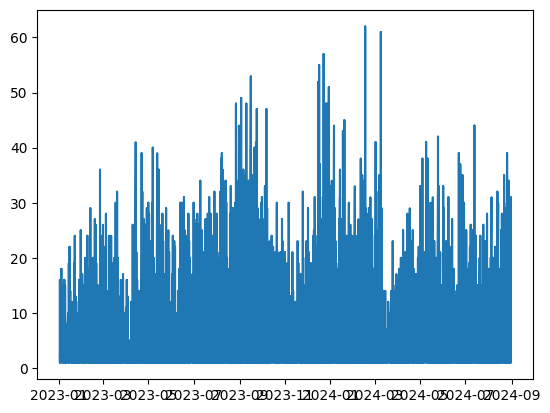

In [35]:
# Vizualisation of 'Quantité' per product
 
import matplotlib.pyplot as plt

plt.plot(order_per_day_product['Jour'], order_per_day_product['Quantité'])

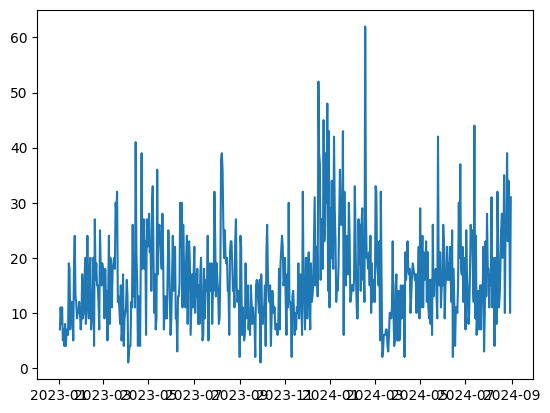

In [43]:
smok = df[df['Produit'] == 'POP SMOKE']
smok_total_order_day = smok.groupby('Jour')['Quantité'].sum().reset_index().sort_values(by='Jour', ascending=True)
plt.plot(smok_total_order_day['Jour'], smok_total_order_day['Quantité'])


In [ ]:
# interactive graph of 'Quantité' per product


